# 将具有相同输入的并行分支分区

In [1]:
from testing import viz_expr # 可视化 relay

In [2]:
import tvm
from tvm import relay
from tvm.relay.dataflow_pattern import *

`conv2d` 的两个消费者（`add` 和 `multiply`）位于两个不同的分支上，它们被合并到一个分区中，确保分区后的函数没有多余的参数。

构建计算图：

In [3]:
i = relay.Var("input")
w = relay.Var("weight")
l = relay.Var("left")
r = relay.Var("right")

conv2d = relay.op.nn.conv2d(i, w)
branch1 = relay.multiply(l, conv2d)
branch2 = relay.add(conv2d, r)
add = relay.add(branch1, branch2)

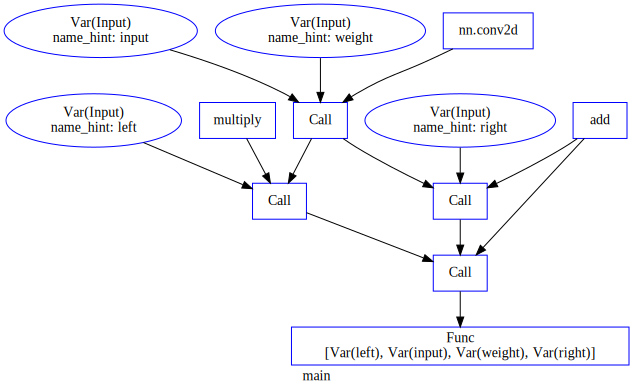

In [4]:
viz_expr(add)

In [5]:
print(tvm.IRModule.from_expr(add))

def @main(%left, %input, %weight, %right) {
  %0 = nn.conv2d(%input, %weight, padding=[0, 0, 0, 0]);
  %1 = multiply(%left, %0);
  %2 = add(%0, %right);
  add(%1, %2)
}



构建模式：

In [6]:
# Pattern
path1 = is_op("multiply")(wildcard(), wildcard())
path2 = is_op("add")(wildcard(), wildcard())
pattern = is_op("add")(path1, path2)

分割计算图：

In [7]:
partitioned = pattern.partition(add)

In [8]:
print(tvm.IRModule.from_expr(partitioned))

def @main(%left, %input, %weight, %right) {
  %2 = nn.conv2d(%input, %weight, padding=[0, 0, 0, 0]);
  %3 = fn (%FunctionVar_0_0, %FunctionVar_0_1, %FunctionVar_0_2, PartitionedFromPattern="multiply_add_add_") {
    %0 = multiply(%FunctionVar_0_0, %FunctionVar_0_1);
    %1 = add(%FunctionVar_0_1, %FunctionVar_0_2);
    add(%0, %1)
  };
  %3(%left, %2, %right)
}

